# Abelian Sandpile

This notebook answers the questions given in the assignment, and removes all the extra explanations. The questions we wanted to answer were:

1. Implement the Abelian Sandpile model and simulate its dynamics. I've included a template of for the solution below, although feel free to re-factor if you would prefer to implement the problem a different way.
2. Using the code included below, show that your model exhibits a $1/T^\alpha$ waiting time between avalanches, where $\alpha$ is some constant.
3. If a single image of the sandpile has size $N$ (the total number of lattice sites), what do you expect to be the worst-case scaling of the runtime of your algorithm? What about the expected scaling of memory usage?
4. (Hard, optional) Try [vectorizing](https://realpython.com/numpy-array-programming/) your sandpile implementation, in order to reduce the number of "for" loops used in your implementation. How does vectorization affect the runtime?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1

In [3]:
# First addressing question one, which is just implementing the Abelian sandpile. I really just edited the given shell

from tkinter import N
from turtle import end_fill


class AbelianSandpile:
    """
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.
    
    Parameters:
    n (int): The size of the grid
    grid (np.ndarray): The grid of the sandpile
    history (list): A list of the sandpile grids at each timestep
    all_durations (list): A list of the durations of each avalanche
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?
        self.all_durations = list() # useful to keep track of the duration of toppling events
        # I'm adding this, not sure yet if needed
        self.avalanch_happened = list()  # a place to keep track of the step at which an avalanch happened
        self.total_changes = list() # a place to keep track of the total changes that occur per step

    # I added this function to the class, this is how I'll have a cell check its neighbors
    # (and then they'll check their neighbors (and then they'll check their neighbors...))

    def avalanch(grid, n, x, y, k):
        grid[x, y] += 1
        if grid[x,y] >= 4:
            k += 1
            grid[x,y] -= 4
            if x != 0:
                grid, k = AbelianSandpile.avalanch(grid, n, x-1, y, k)
            if x != n-1:
                grid, k = AbelianSandpile.avalanch(grid, n, x+1, y, k)
            if y != 0:
                grid, k = AbelianSandpile.avalanch(grid, n, x, y-1, k)
            if y != n-1:
                grid, k = AbelianSandpile.avalanch(grid, n, x, y+1, k)

        return grid, k


    def step(self):
        """
        Perform a single step of the sandpile model. Recall that there are two 
        timescales in this problem; step corresponds to the longer timescale of a 
        single sandgrain addition.

        A single step of the simulation consists of two stages: a random sand grain is 
        dropped onto the lattice at a random location. Then, a set of avalanches occurs
        causing sandgrains to get redistributed to their neighboring locations.

        Returns: None
        """
        
        ########## my code here ############

        # First deciding where we want to drop a grain of sand

        drop = np.random.choice(np.arange(0, self.n), size = (2))

        # Now we want to solve for the toppling events, based on where the grain fell
        
        grid_new, k = AbelianSandpile.avalanch(self.grid, self.n, drop[0], drop[1], 0)

        self.history.append(grid_new.copy())
        self.all_durations.append(k)
        self.grid = grid_new

    # we use this decorator for class methods that don't require any of the attributes 
    # stored in self. Notice how we don't pass self to the method
    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    
    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps.
        """
        # My code: 
        for j in np.arange(0, n_step+1):
            AbelianSandpile.step(self)
            total_change= AbelianSandpile.check_difference(self.history[j], self.history[j-1])

            # adding the below lists

            self.total_changes.append(total_change)
            if total_change > 1:
                self.avalanch_happened.append(j)

Text(0.5, 1.0, 'Avalanch activity in most recent timesteps')

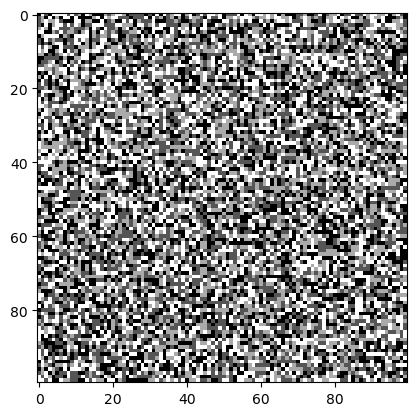

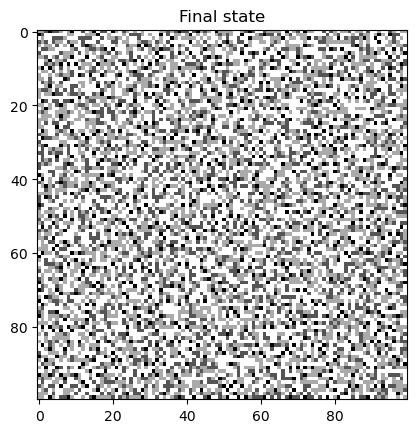

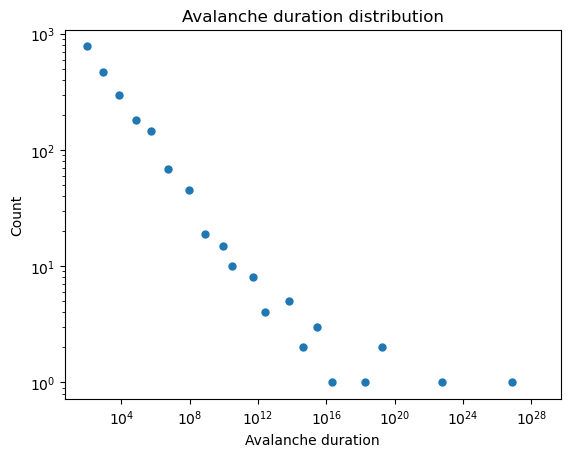

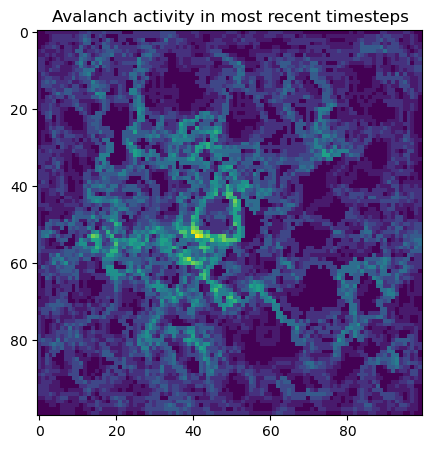

In [4]:
# this block runs the simulation and produces pretty plots (all from the original jupyter notebook)

## Import William's solution from answer key
# from solutions.sandpile import AbelianSandpile

# Run sandpile simulation
model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')

model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")

# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events = [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]

log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(10**bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanch activity in most recent timesteps")

## Problem 2

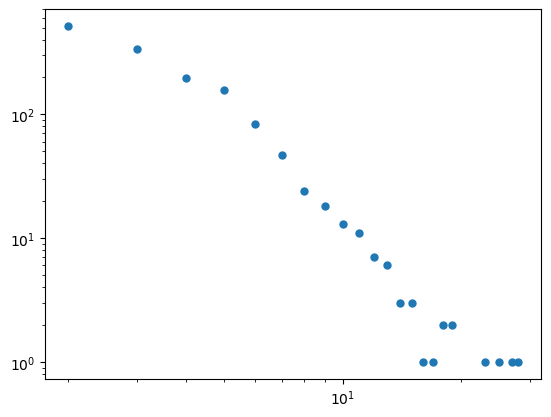

In [22]:
# Now we want to show that there is a 1 / T^{alpha} waiting time between avalanch events. I added to the class
# above a list that will keep track of the steps (j values) where an avalanch occurs 

# first computing the pairwise difference between the steps that had an avalanch, i.e. how long we 
# waited before another avalanch occured 
wait = [(event1 - event0 - 1) for event0, event1 in zip(model.avalanch_happened[:-1], model.avalanch_happened[1:])]

bins = np.arange(2, np.max(wait) + 1) # logarithmic bins for histogram
vals, bins = np.histogram(wait, bins=bins)
plt.figure()
plt.loglog(bins[:-1], vals, '.', markersize=10)

##### not finished ########

In [18]:
np.max(wait)

29

# Percolation 

1. Implement a two dimensional directed percolation model in Python. I've included my code outline below.
    + The naive solution simulates water pouring into the top row, and then iterate over rows and sites
    + Can you think of a faster way of solving this problem? (Hint: we may not have seen recursion in class yet, but it may be helpful). If you want to try implementing your solution, you will need to add an additional private method `_flow_recursive(i, j)` that contains the recursive logic
2. Perform replicate simulations using the code I've provided below, create a plot showing how the probability of percolation changes as a function of N (the lattice size). Beyond seeing the predictable percolation to clogging transition, you'll notice that the variance in the outcome of your simulations behaves unexpectedly. What is going on here? (Hint: If you've studied the Ising model, you've seen something like this before)
3. Theoretically, does the transition point seen in our empirical results align with your intuition? Can you make a simple statistical argument for the percolation threshold? (Hint: think about counting occupied sites versus counting links between sites).
4. How does the memory usage and runtime of your percolation model implement scale with the lattice size? You can answer this empirically or theoretically.
5. For the sandpile model, we noted the existence of two timescales: the slow timescale (addition of sand grains) and the fast timescale (avalanches and topples). These two timescales were reflected in how we chose to implement our simulation. What are the relevant timescales for the directed percolation simulation? (Hint: watch the videos of the simulation on the class website for ideas)